<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import modules</a></span></li><li><span><a href="#Framing-Time-Series-As-Supervised-Learning-Problem" data-toc-modified-id="Framing-Time-Series-As-Supervised-Learning-Problem-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Framing Time Series As Supervised Learning Problem</a></span></li><li><span><a href="#Load-dataset" data-toc-modified-id="Load-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load dataset</a></span></li><li><span><a href="#Features-engineering" data-toc-modified-id="Features-engineering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Features engineering</a></span></li><li><span><a href="#Split-the-data" data-toc-modified-id="Split-the-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Split the data</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Learning-curves" data-toc-modified-id="Learning-curves-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Learning curves</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#Forecast-with-prediction-intervals" data-toc-modified-id="Forecast-with-prediction-intervals-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Forecast with prediction intervals</a></span></li><li><span><a href="#Feature-importance" data-toc-modified-id="Feature-importance-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Feature importance</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#References" data-toc-modified-id="References-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** Using CV to get PIs using random forest for time series

</font>
</div>

# Import modules
<hr style="border:2px solid black"> </hr>

In [76]:
import numpy as np
import pandas as pd
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

rcParams['figure.figsize'] = 15, 5
rcParams['font.size'] = 16

# Framing Time Series As Supervised Learning Problem
<hr style="border:2px solid black"> </hr>

<div class="alert alert-block alert-info">
<font color=black><br>

- Before we apply these supervised learning methods on our time series data. 
- There are 4 classes of time series based features that we can create:
    
    - **Date & time features**. e.g. Given the date 2019-08-02, we can extract features such as year, month and date to create 3 additional features out of the original timestamp. 
    - **Lag features**. a.k.a values at prior time steps.
    - **Window features**. These are summary statistics over a fixed window.
    - **Time until next event / Time since last event**.

<br></font>
</div>

# Load dataset
<hr style="border:2px solid black"> </hr>

In [3]:
ads_col = 'Ads'
time_col = 'Time'
input_path = "../DATASETS/ads.csv"
ads = pd.read_csv(input_path, index_col=time_col, parse_dates=[time_col])
print('dimension: ', ads.shape)
ads.head()

dimension:  (216, 1)


,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


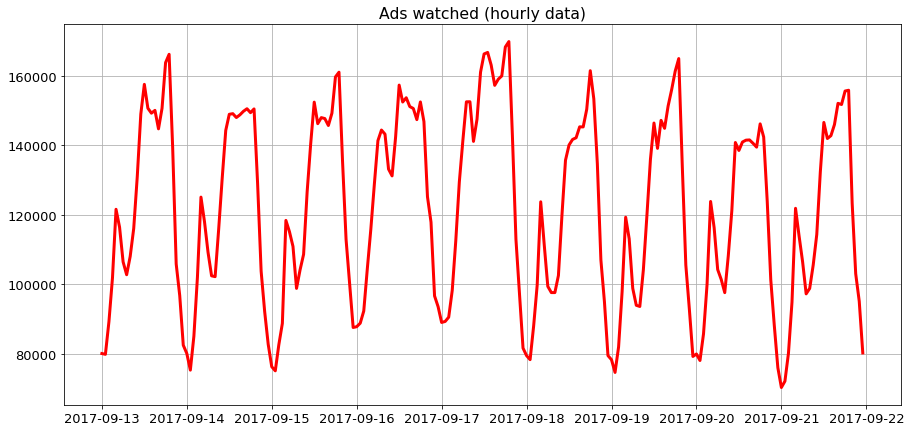

In [14]:
# required datetime converter for matplotlib plotting
register_matplotlib_converters()
plt.figure(figsize=(15, 7))
plt.plot(ads[ads_col], "r-", lw=3)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

# Features engineering
<hr style="border:2px solid black"> </hr>

<div class="alert alert-block alert-info">
<font color=black><br>

- Generating lagged features and window statistics from them.
- We will also add date & time features such as hour of the day, day of the week and a boolean feature indicating whether this is a weekend.
- **Window statistics**: mean of the lagged features we've created.

<br></font>
</div>

In [15]:
label_col = 'y'
data = pd.DataFrame(ads[ads_col].copy())
data.columns = [label_col]

# Add the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data['lag_{}'.format(i)] = data[label_col].shift(i)

data['hour'] = data.index.hour
data['weekday'] = data.index.weekday
data['is_weekend'] = data['weekday'].isin([5, 6]).astype(np.int)

data = data.dropna()
data.head()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-14 00:00:00,80125,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,...,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,80115.0,0,3,0
2017-09-14 01:00:00,75335,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,...,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,1,3,0
2017-09-14 02:00:00,85105,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,...,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,2,3,0
2017-09-14 03:00:00,102080,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,...,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,3,3,0
2017-09-14 04:00:00,125135,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,...,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,4,3,0


In [16]:
lag_cols = [col for col in data.columns if 'lag' in col]
data['rolling_mean'] = data[lag_cols].mean(axis=1)

# extract out the features and labels into separate variables
y = data[label_col].values
data = data.drop(label_col, axis=1)

X = data.values
feature_names = data.columns
print('dimension: ', X.shape)
data.head()

dimension:  (192, 23)


,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend,rolling_mean
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-14 00:00:00,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,116125.0,...,116475.0,121630.0,101930.0,89325.0,79885.0,80115.0,0,3,0,124731.052632
2017-09-14 01:00:00,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,...,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,1,3,0,129263.684211
2017-09-14 02:00:00,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,...,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,2,3,0,132402.368421
2017-09-14 03:00:00,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,...,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,3,3,0,133274.473684
2017-09-14 04:00:00,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,...,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,4,3,0,133003.421053


# Split the data
<hr style="border:2px solid black"> </hr>

In [22]:
def timeseries_train_test_split(X, y, test_size=0.3):
    """Perform train-test split with respect to time series structure."""
    test_index = int(len(X) * (1 - test_size))
    X_train = X[:test_index]
    X_test = X[test_index:]
    y_train = y[:test_index]
    y_test = y[test_index:]
    return X_train, X_test, y_train, y_test

In [24]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y)

# Model
<hr style="border:2px solid black"> </hr>

In [51]:
model = RandomForestRegressor(max_depth=6, n_estimators=50)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
predictionTrain = model.predict(X_train)

In [45]:
pd.DataFrame(X_test)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,93660.0,94000.0,98880.0,113115.0,119345.0,97950.0,81990.0,74670.0,78335.0,79515.0,...,153415.0,161520.0,150410.0,145335.0,145360.0,142220.0,14.0,1.0,0.0,114028.947368
1,104185.0,93660.0,94000.0,98880.0,113115.0,119345.0,97950.0,81990.0,74670.0,78335.0,...,134720.0,153415.0,161520.0,150410.0,145335.0,145360.0,15.0,1.0,0.0,112027.105263
2,119750.0,104185.0,93660.0,94000.0,98880.0,113115.0,119345.0,97950.0,81990.0,74670.0,...,107065.0,134720.0,153415.0,161520.0,150410.0,145335.0,16.0,1.0,0.0,110679.210526
3,135990.0,119750.0,104185.0,93660.0,94000.0,98880.0,113115.0,119345.0,97950.0,81990.0,...,95045.0,107065.0,134720.0,153415.0,161520.0,150410.0,17.0,1.0,0.0,110187.368421
4,146455.0,135990.0,119750.0,104185.0,93660.0,94000.0,98880.0,113115.0,119345.0,97950.0,...,79515.0,95045.0,107065.0,134720.0,153415.0,161520.0,18.0,1.0,0.0,109979.210526
5,139165.0,146455.0,135990.0,119750.0,104185.0,93660.0,94000.0,98880.0,113115.0,119345.0,...,78335.0,79515.0,95045.0,107065.0,134720.0,153415.0,19.0,1.0,0.0,108802.631579
6,147225.0,139165.0,146455.0,135990.0,119750.0,104185.0,93660.0,94000.0,98880.0,113115.0,...,74670.0,78335.0,79515.0,95045.0,107065.0,134720.0,20.0,1.0,0.0,108476.842105
7,144935.0,147225.0,139165.0,146455.0,135990.0,119750.0,104185.0,93660.0,94000.0,98880.0,...,81990.0,74670.0,78335.0,79515.0,95045.0,107065.0,21.0,1.0,0.0,109014.473684
8,151370.0,144935.0,147225.0,139165.0,146455.0,135990.0,119750.0,104185.0,93660.0,94000.0,...,97950.0,81990.0,74670.0,78335.0,79515.0,95045.0,22.0,1.0,0.0,111346.315789
9,156080.0,151370.0,144935.0,147225.0,139165.0,146455.0,135990.0,119750.0,104185.0,93660.0,...,119345.0,97950.0,81990.0,74670.0,78335.0,79515.0,23.0,1.0,0.0,114558.684211


In [28]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
error = mean_absolute_percentage_error(prediction, y_test)
print('Mean absolute percentage error {0:.2f}%'.format(error))

Mean absolute percentage error 3.93%


# Learning curves
<hr style="border:2px solid black"> </hr>

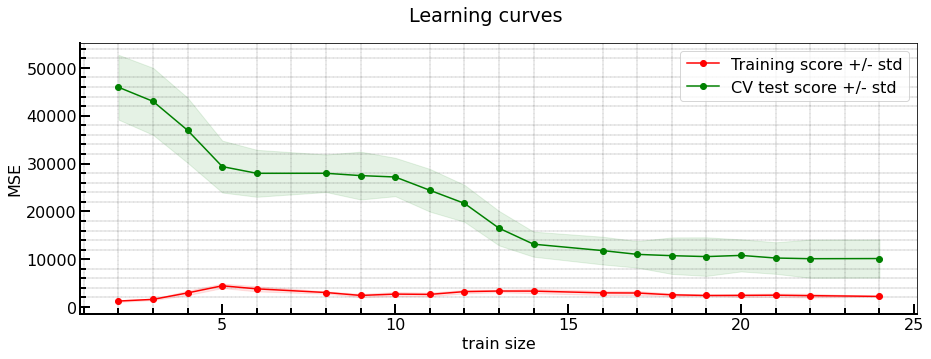

In [79]:
train_sizes, train_scores, test_scores = learning_curve(model,
                                                        X_train,
                                                        y_train,
                                                        cv=timeseries_cv,
                                                        n_jobs=-1,
                                                        train_sizes=np.linspace(
                                                            0.1, 1, 20),
                                                        scoring="neg_mean_absolute_error")

train_scores_mean = -1*np.mean(train_scores, axis=1)
train_scores_std = -1*np.std(train_scores, axis=1)
test_scores_mean = -1*np.mean(test_scores, axis=1)
test_scores_std = -1*np.std(test_scores, axis=1)


# Plot learning curve
fig = plt.figure()
fig.suptitle("Learning curves")
ax = fig.add_subplot(111)

ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.1,
                color="r")
ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.1,
                color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score +/- std")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="CV test score +/- std")

ax.grid(which="major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which="minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which='major', direction='in', length=10, width=2)
ax.tick_params(which='minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.set_xlabel("train size")
ax.set_ylabel("MSE")

plt.legend(loc="best")
plt.grid()

# Plotting
<hr style="border:2px solid black"> </hr>

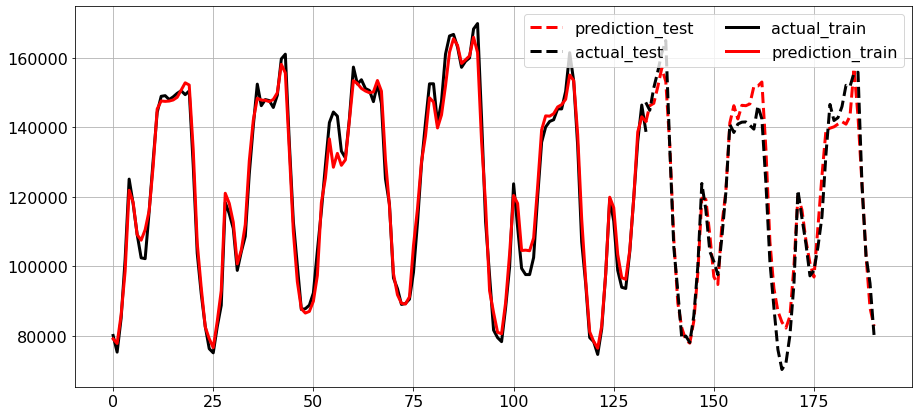

In [70]:
plt.figure(figsize=(15, 7))


x_train = range(y_train.size)

x = [i + max(x_train) for i in range(prediction.size)]

plt.plot(x, prediction, "r--", lw = 3, label='prediction_test')
plt.plot(x, y_test, "k--", lw = 3, label='actual_test')

plt.plot(x_train, y_train, "k-", lw = 3, label='actual_train')
plt.plot(x_train, predictionTrain, "r-", lw = 3, label='prediction_train')

plt.legend(loc='best', ncol = 2)
plt.grid(True)

# Forecast with prediction intervals
<hr style="border:2px solid black"> </hr>

<div class="alert alert-block alert-info">
<font color=black><br>

- The way we are getting the prediction interval here is a bit unusual but still valid.
- We are pulling out the standard deviation from the cross validation procedure.
- **For me there is still a question whethere this approach is appropriate or not?**
-

<br></font>
</div>

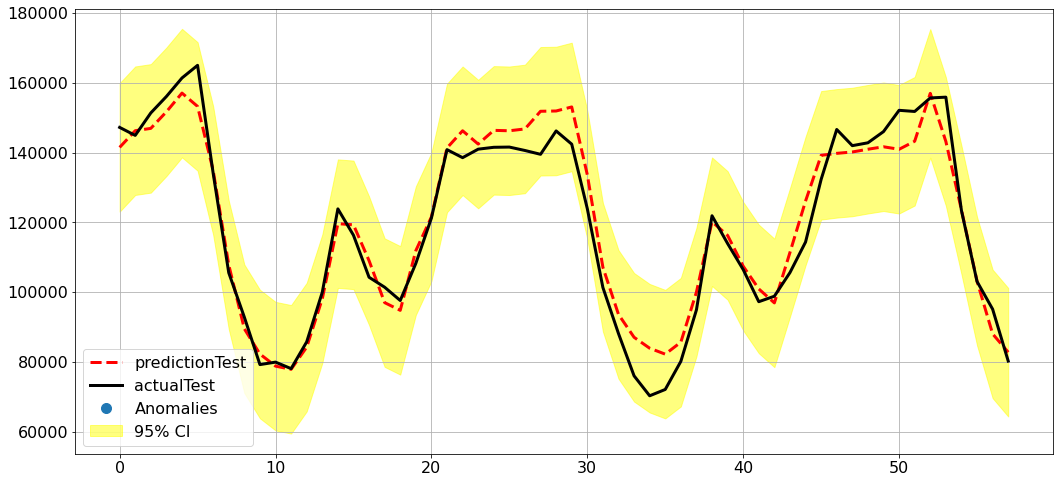

In [74]:
plt.figure(figsize=(15, 7))

x = range(prediction.size)
plt.plot(x, prediction, "r--", lw=3, label='predictionTest')
plt.plot(x, y_test, "k-", lw=3, label='actualTest')

# Plotting predictio interval
timeseries_cv = TimeSeriesSplit(n_splits=5)
cv = cross_val_score(model,
                     X_train, y_train,
                     cv=timeseries_cv,
                     scoring='neg_mean_absolute_error')
mae = -1 * cv.mean()
deviation = cv.std()

# hard-coded to be 95% confidence interval
scale = 1.96
margin_error = mae + scale * deviation
lower = prediction - margin_error
upper = prediction + margin_error

fill_alpha = 0.5
fill_color = 'yellow'
plt.fill_between(x, lower, upper, color=fill_color,
                 alpha=fill_alpha, label='95% CI')

# Plotting anomalies if any
anomalies = np.array([np.nan] * len(y_test))
anomalies[y_test < lower] = y_test[y_test < lower]
anomalies[y_test > upper] = y_test[y_test > upper]
plt.plot(anomalies, 'o', markersize=10, label='Anomalies')

plt.legend(loc='best')
plt.tight_layout()
plt.grid(True)

<div class="alert alert-block alert-info">
<font color=black><br>

- **If nothing unexpected happens we expect to be within ±x %, but if assumptions a, b, or c perform differently than expected, we might be as much as ±y% off.**

- For the **±x%** part, notice that in this documentation, we added a confidence interval functionality to our time series forecasting plot. This is where the confidence interval part can come in handy.
- Whereas Monte Carlo simulation can come in handy for the second part of the sentence **±y %** (if assumptions a, b, or c perform differently ...). 

<br></font>
</div>

# Feature importance
<hr style="border:2px solid black"> </hr>

<div class="alert alert-block alert-info">
<font color=black><br>

- The most important feature is `lag_24` (each lag is an hour for this dataset), which is not a surprise as yesterday's value is usually a good indicator of what the value is going to be today.
- More all the other feature have a standard deviation way bigger than their value, so they cannnot really be used.

<br></font>
</div>

Text(0.5, 1.0, 'Feature Importance Plot')

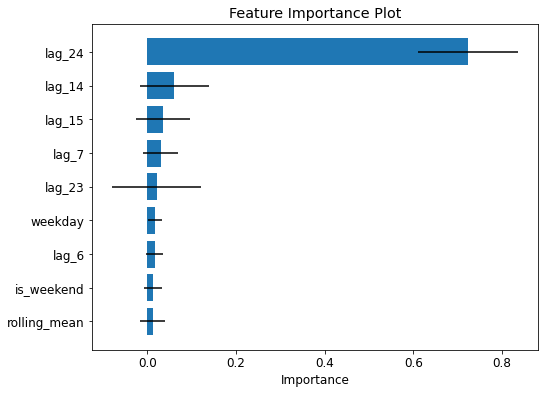

In [86]:
filtered_names = None
estimator = model
threshold = 0.01

imp = estimator.feature_importances_
feature_names = np.array(feature_names)
if filtered_names is not None:
    keep = ~np.in1d(feature_names, filtered_names, assume_unique=True)
    mask = np.logical_and(imp > threshold, keep)
else:
    mask = imp > threshold

importances = imp[mask]
idx = np.argsort(importances)
scores = importances[idx]
names = feature_names[mask]
names = names[idx]

y_pos = np.arange(1, len(scores) + 1)
if hasattr(estimator, 'estimators_'):
    # apart from the mean feature importance, for scikit-learn we can access
    # each individual tree's feature importance and compute the standard deviation
    tree_importances = np.array([tree.feature_importances_
                                 for tree in estimator.estimators_])
    importances_std = np.std(tree_importances[:, mask], axis=0)
    scores_std = importances_std[idx]
    plt.barh(y_pos, scores, align='center', xerr=scores_std)
else:
    plt.barh(y_pos, scores, align='center')

plt.yticks(y_pos, names)
plt.xlabel('Importance')
plt.title('Feature Importance Plot')

# Conclusions
<hr style="border:2px solid black"> </hr>

<div class="alert alert-danger">
<font color=black>

- Confidence and prediction intervals are not the same thing.
- While plotting the feature importance please make sure you also report the standard deviation.

</font>
</div>

# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-block alert-warning">
<font color=black>

- [Blog: Time Series Forecasting as Supervised Learning](https://machinelearningmastery.com/time-series-forecasting-supervised-learning/)
- [Blog: How to Convert a Time Series to a Supervised Learning Problem in Python](http://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)
- [Blog: Basic Feature Engineering With Time Series Data in Python](https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/)
- [Blog: What's wrong with my time series? Model validation without a hold-out set
](https://blog.insightdatascience.com/whats-wrong-with-my-time-series-model-validation-without-a-hold-out-set-94151d38cf5b)
- [Jupyter Notebook: Open Machine Learning Course - Time series analysis in Python](http://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb)
- [This notebook](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/time_series/3_supervised_time_series.ipynb)

</font>
</div>